In [11]:
import os
import sys
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model

In [12]:
# =============================================================================
# 1. 환경 설정
# =============================================================================
# utils.py가 있는 프로젝트 루트 경로를 시스템 경로에 추가
PROJECT_ROOT = '/content/drive/MyDrive/Colab Notebooks/HAR_Research_Project'
sys.path.append(PROJECT_ROOT)

# Custom Layer 로드 (모델 로딩 시 아키텍처 의존성 해결을 위해 필요)
try:
    from utils import (
    squeeze_excite_block, cbam_block, transformer_encoder, categorical_focal_loss,
    spatial_shape, cbam_reduce_mean, cbam_reduce_max
)
    print("✅ utils.py 로드 성공: Custom Layers 준비 완료")
except ImportError:
    print("❌ utils.py를 찾을 수 없습니다. 경로를 확인해주세요.")

# 결과 저장 경로 설정
RESULT_DIR = f'{PROJECT_ROOT}/results'
if not os.path.exists(RESULT_DIR):
    os.makedirs(RESULT_DIR)

✅ utils.py 로드 성공: Custom Layers 준비 완료


In [13]:
# 1. 날짜 필터 (예: '20251204' 또는 None)
# None이면 모든 날짜의 파일을 다 불러옵니다.
FILTER_DATE = '20251204'

# 2. 모델 필터 (리스트 형태, 예: ['se_resnet'] 또는 [])
# 빈 리스트 []면 모든 모델을 다 불러옵니다.
FILTER_MODELS = []
# 예시: ['se_resnet', 'cbam_resnet']

# 3. 데이터셋 필터 (예: 'UCI' 또는 None)
FILTER_DATASET = None

In [14]:
# =============================================================================
# 2. 테스트 데이터 로드 함수 정의
# =============================================================================
def load_test_data(dataset_name):
    """
    1. 데이터셋 이름에 따라 로드 방식 분기 (UCI vs 그 외)
    2. 학습 시와 동일한 전처리(스케일링) 적용
    3. 최종 Test Set 반환
    """
    print(f"\n[Data Loading] {dataset_name} 데이터셋 로드 중...")
    data_dir = f'{PROJECT_ROOT}/data/processed'

    try:
        # [Case A] UCI-HAR: 고정된 파일 로드
        if dataset_name == 'UCI':
            # 스케일러 학습(fit)을 위해 Train 데이터도 필요함
            X_train = np.load(f'{data_dir}/{dataset_name}_X_train.npy')

            # 실제 평가할 Test 데이터 로드
            X_test = np.load(f'{data_dir}/{dataset_name}_X_test.npy')
            y_test = np.load(f'{data_dir}/{dataset_name}_y_test.npy')

            print("   -> Mode: Fixed Split (Official)")

        # [Case B] 그 외: 전체 파일 로드 후 Random Split (학습과 동일 로직)
        else:
            X = np.load(f'{data_dir}/{dataset_name}_X.npy')
            y = np.load(f'{data_dir}/{dataset_name}_y.npy')

            # 학습 코드와 동일한 Seed(42)로 분할하여 Test Set 확보
            # 1차: Train(60%) vs Temp(40%)
            X_train, X_temp, y_train, y_temp = train_test_split(
                X, y, test_size=0.4, random_state=42, stratify=y
            )
            # 2차: Val(20%) vs Test(20%) -> 여기서 X_test 확보
            _, X_test, _, y_test = train_test_split(
                X_temp, y_temp, test_size=0.5, random_state=42, stratify=np.argmax(y_temp, axis=1) if len(y_temp.shape)>1 else y_temp
            )
            print("   -> Mode: Random Split (Seed 42)")

        # ---------------------------------------------------------
        # 스케일링 (Scaling)
        # 학습된 모델은 스케일링된 데이터를 입력받으므로, 여기서도 똑같이 해줘야 함
        # 규칙: Train 데이터로 fit하고, Test 데이터는 transform만 한다.
        # ---------------------------------------------------------
        scaler = StandardScaler()
        N, T, F = X_train.shape

        # Train으로 기준 잡기
        scaler.fit(X_train.reshape(-1, F))

        # Test 데이터 변환
        X_test = scaler.transform(X_test.reshape(-1, F)).reshape(X_test.shape)

        # One-hot Encoding
        n_classes = len(np.unique(y_test)) # y가 정수형이라고 가정

        # UCI y_train/test 파일이 이미 0~N 정수형인지 확인 필요
        # 만약 One-hot이 안 되어 있다면 변환
        if len(y_test.shape) == 1:
            y_test_hot = tf.keras.utils.to_categorical(y_test, n_classes)
        else:
            y_test_hot = y_test
            n_classes = y_test.shape[1] # 이미 One-hot인 경우

        print(f"   -> Test Set Shape: {X_test.shape}, Classes: {n_classes}")
        return X_test, y_test_hot, n_classes

    except Exception as e:
        print(f"⚠️ Warning: {dataset_name} 데이터를 로드할 수 없습니다. ({e})")
        return None, None, None

In [15]:
# =============================================================================
# 3. 모델 평가 루프 (Evaluation Loop)
# =============================================================================
checkpoint_dir = f'{PROJECT_ROOT}/checkpoints'
if not os.path.exists(checkpoint_dir):
    print("❌ Checkpoints 폴더가 없습니다.")
    model_files = []
else:
    # .keras 또는 .h5 파일 모두 검색
    model_files = [f for f in os.listdir(checkpoint_dir) if f.endswith('.keras') or f.endswith('.h5')]

results = []
filtered_files = []

# [필터링 로직]
print(f"\n🔍 Filtering Models... (Total found: {len(model_files)})")
for f in model_files:
    # 1. 날짜 필터
    if FILTER_DATE and (FILTER_DATE not in f):
        continue
    # 2. 모델명 필터
    if FILTER_MODELS and not any(m in f for m in FILTER_MODELS):
        continue
    # 3. 데이터셋 필터
    if FILTER_DATASET and (FILTER_DATASET not in f):
        continue

    filtered_files.append(f)

print(f"✅ Selected {len(filtered_files)} models for evaluation.\n")

# 평가 시작
for file_name in sorted(filtered_files):
    print(f"⚡ Processing: {file_name} ...")

    # 파일명 파싱 (예: best_model_UCI_se_resnet_20251204.keras)
    try:
        name_clean = file_name.replace('.keras', '').replace('.h5', '')
        parts = name_clean.split('_')
        # parts: ['best', 'model', 'UCI', 'se', 'resnet', '20251204']

        if len(parts) >= 3:
            dataset_name = parts[2]
            # 모델명+태그 (날짜 포함)
            model_variant = "_".join(parts[3:])
        else:
            dataset_name = "Unknown"
            model_variant = name_clean
    except:
        dataset_name = "Error"
        model_variant = file_name

    # 데이터셋 로드
    X_test, y_test, _ = load_test_data(dataset_name)
    if X_test is None: continue

    # 모델 로드 & 예측
    try:
        model = load_model(
            os.path.join(checkpoint_dir, file_name),
            custom_objects={
                'focal_loss_fixed': categorical_focal_loss(),
                'squeeze_excite_block': squeeze_excite_block,
                'cbam_block': cbam_block,
                'transformer_encoder': transformer_encoder,
                'spatial_shape': spatial_shape,
                'cbam_reduce_mean': cbam_reduce_mean,
                'cbam_reduce_max': cbam_reduce_max
            },
            compile=False
        )

        y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
        y_true = np.argmax(y_test, axis=1)

        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='weighted')

        results.append({
            'Dataset': dataset_name,
            'Model_Variant': model_variant,
            'Accuracy': acc,
            'F1-Score': f1
        })
        print(f"   ✅ Acc: {acc:.4f}, F1: {f1:.4f}\n")

    except Exception as e:
        print(f"   ❌ Eval Failed: {e}\n")


🔍 Filtering Models... (Total found: 10)
✅ Selected 5 models for evaluation.

⚡ Processing: best_model_UCI_cbam_resnet_20251204.keras ...

[Data Loading] UCI 데이터셋 로드 중...
   -> Mode: Fixed Split (Official)
   -> Test Set Shape: (2947, 128, 9), Classes: 6
   ✅ Acc: 0.9549, F1: 0.9544

⚡ Processing: best_model_UCI_cnn_bilstm_20251204.keras ...

[Data Loading] UCI 데이터셋 로드 중...
   -> Mode: Fixed Split (Official)
   -> Test Set Shape: (2947, 128, 9), Classes: 6
   ✅ Acc: 0.9440, F1: 0.9439

⚡ Processing: best_model_UCI_resnet_transformer_20251204.keras ...

[Data Loading] UCI 데이터셋 로드 중...
   -> Mode: Fixed Split (Official)
   -> Test Set Shape: (2947, 128, 9), Classes: 6


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'positional_embedding', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


   ✅ Acc: 0.9623, F1: 0.9620

⚡ Processing: best_model_UCI_se_resnet_20251204.keras ...

[Data Loading] UCI 데이터셋 로드 중...
   -> Mode: Fixed Split (Official)
   -> Test Set Shape: (2947, 128, 9), Classes: 6
   ✅ Acc: 0.9396, F1: 0.9394

⚡ Processing: best_model_UCI_standard_resnet_20251204.keras ...

[Data Loading] UCI 데이터셋 로드 중...
   -> Mode: Fixed Split (Official)
   -> Test Set Shape: (2947, 128, 9), Classes: 6
   ✅ Acc: 0.9410, F1: 0.9404




🏆 Final Experiment Results 🏆


,Dataset,Model_Variant,Accuracy,F1-Score
2,UCI,resnet_transformer_20251204,0.962335,0.962010
0,UCI,cbam_resnet_20251204,0.954869,0.954438
1,UCI,cnn_bilstm_20251204,0.944011,0.943903
4,UCI,standard_resnet_20251204,0.940957,0.940400
3,UCI,se_resnet_20251204,0.939600,0.939449



📄 Results saved to: /content/drive/MyDrive/Colab Notebooks/HAR_Research_Project/results/final_benchmark_20251203.csv
📊 Graph saved to: /content/drive/MyDrive/Colab Notebooks/HAR_Research_Project/results/final_comparison_graph_20251203.png


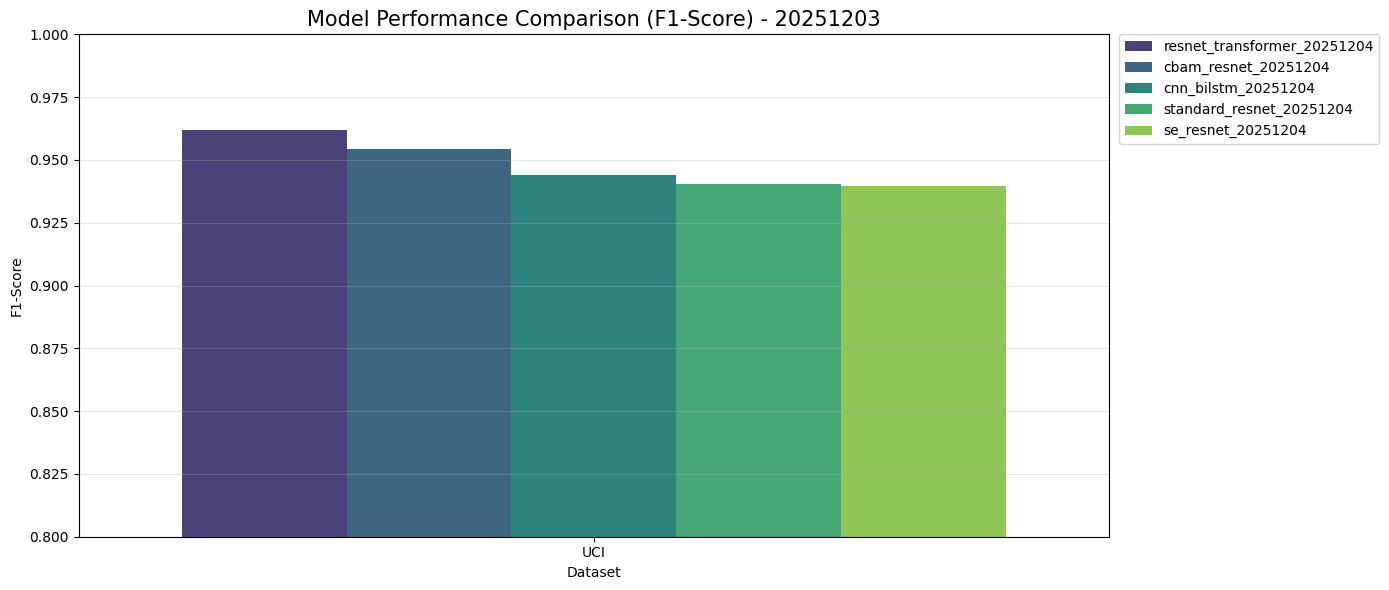

In [19]:
# =============================================================================
# 4. 최종 결과 리포팅 및 시각화
# =============================================================================
if results:
    # DataFrame 생성 및 정렬
    df_results = pd.DataFrame(results)
    df_results = df_results.sort_values(by=['Dataset', 'F1-Score'], ascending=[True, False])

    print("\n🏆 Final Experiment Results 🏆")
    try:
        display(df_results)
    except:
        print(df_results)

    # 오늘 날짜
    today_date = "20251204"

    # 1. 결과 CSV 저장 (날짜 포함)
    csv_filename = f'final_benchmark_{today_date}.csv'
    csv_path = f'{RESULT_DIR}/{csv_filename}'
    df_results.to_csv(csv_path, index=False)
    print(f"\n📄 Results saved to: {csv_path}")

    # 2. 비교 그래프 시각화 (Bar Chart)
    plt.figure(figsize=(14, 6))

    # Seaborn Barplot
    sns.barplot(data=df_results, x='Dataset', y='F1-Score', hue='Model_Variant', palette='viridis')

    plt.title(f"Model Performance Comparison (F1-Score) - {today_date}", fontsize=15)
    plt.ylim(0.8, 1.0)
    plt.grid(axis='y', alpha=0.3)
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout()

    # 그래프 이미지 저장
    img_filename = f'final_comparison_graph_{today_date}.png'
    img_path = f'{RESULT_DIR}/{img_filename}'
    plt.savefig(img_path)
    print(f"📊 Graph saved to: {img_path}")
    plt.show()

else:
    print("⚠️ 결과가 없습니다. checkpoints 폴더에 학습된 모델(.h5 / .keras)이 있는지 확인하세요.")